import jupedsim as jps
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pedpy

from shapely import Polygon

%matplotlib inline

## Setup simulation

In [45]:
num_agents = 10

area = Polygon(
    [(-10, 10), (10, 10), (10, -10), (-10, -10)]
)

spawning_areas = [
    Polygon([(0, 0), (6, 0), (6, 2), (0, 2)]),
    Polygon([(0, 0), (6, 0), (6, 2), (0, 2)]),
]


pos_in_spawning_area = jps.distributions.distribute_by_number(
    polygon=spawning_area,
    number_of_agents=num_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.2,
    seed=1,
)

exit_area = Polygon([(10, 11), (12, 11), (12, 12), (10, 12)])

walkable_area = pedpy.WalkableArea(area)
exit_area = Polygon([(-2, 10), (2, 10), (2, 8), (-2, 8)])

## Plot 

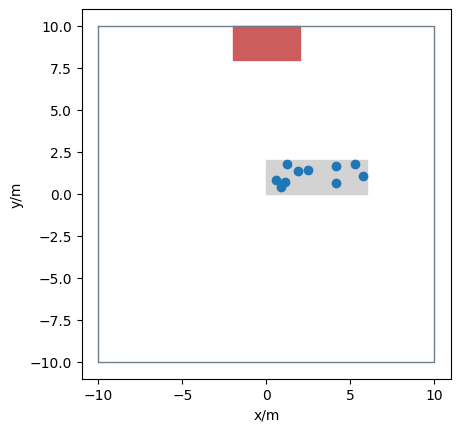

In [46]:
axes = pedpy.plot_walkable_area(walkable_area=walkable_area)

# Spawning area
axes.fill(*spawning_area.exterior.xy, color="lightgrey")

# Exit area
axes.fill(*exit_area.exterior.xy, color="indianred")

# Starting positions
axes.scatter(*zip(*pos_in_spawning_area))

axes.set_aspect("equal")

In [47]:
trajectory_file = "corner.sqlite"
simulation = jps.Simulation(
    model=jps.CollisionFreeSpeedModel(),
    geometry=area,
    trajectory_writer=jps.SqliteTrajectoryWriter(
        output_file=pathlib.Path(trajectory_file)
    ),
)

exit_id = simulation.add_exit_stage(exit_area.exterior.coords[:-1])
journey = jps.JourneyDescription([exit_id])
journey_id = simulation.add_journey(journey)

In [48]:
v_distribution = np.random.normal(1.34, 0.05, num_agents)

for pos, v0 in zip(pos_in_spawning_area, v_distribution):
    simulation.add_agent(
        jps.CollisionFreeSpeedModelAgentParameters(
            journey_id=journey_id, stage_id=exit_id, position=pos, v0=v0
        )
    )

while simulation.agent_count() > 0:
    simulation.iterate()

## Trajectory animation

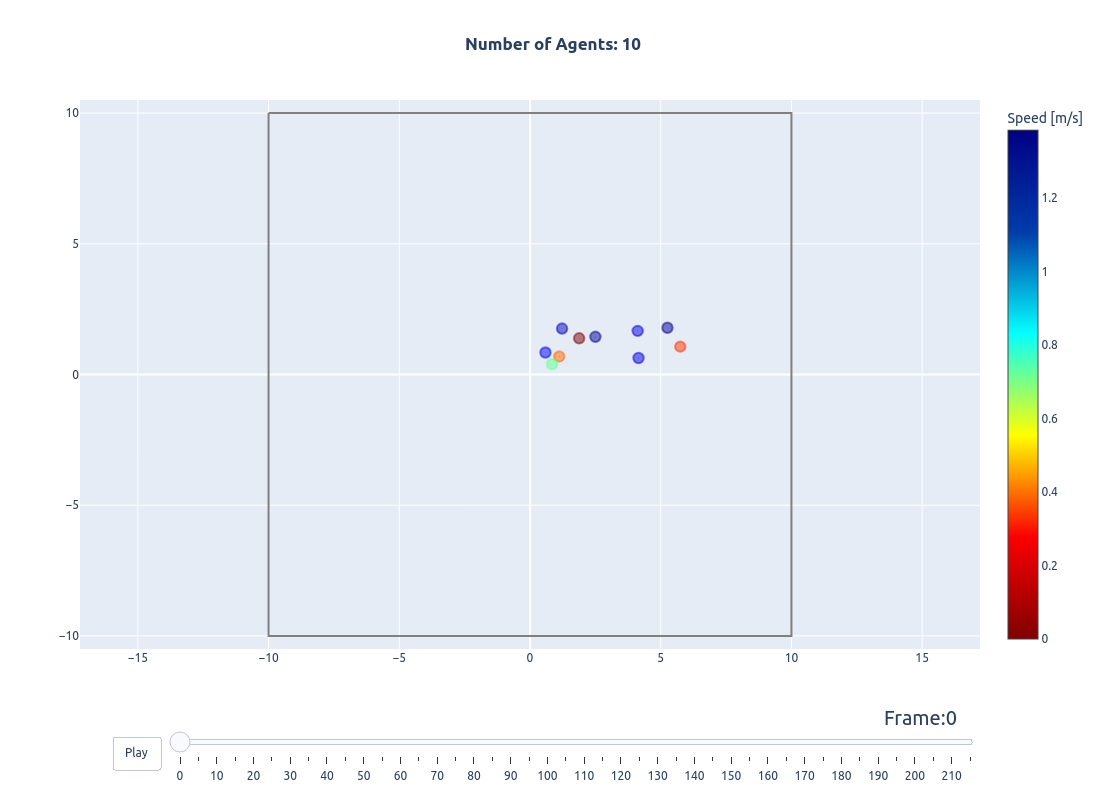

In [52]:
from jupedsim.internal.notebook_utils import animate, read_sqlite_file

trajectory_data, walkable_area = read_sqlite_file(trajectory_file)
animate(trajectory_data, walkable_area, every_nth_frame=5)